In [2]:
import cv2
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

In [3]:
# Download data from https://www.kaggle.com/datasets/fmena14/crowd-counting/code
# data size too big cannot updload to github
images = np.load("../data/images.npy")      # size: 640*480
label = np.load("../data/labels.npy")

In [ ]:
# Wider Pedestrian Dataset (https://drive.google.com/file/d/1I7OjhaomWqd8Quf7o5suwLloRlY0THbp/view)
# extension of the Wider Face dataset and focuses on pedestrian detection


# Default HogDescriptor

In [3]:
def count_people(image):
    # Load the pre-trained HOG people detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    # Convert the image to grayscale for HOG detector
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect people in the image
    people, _ = hog.detectMultiScale(image)

    # Return the count of detected people
    return len(people)

In [4]:
countErr = []
for img, lab in zip(images[:100], label[:100]):
    count = count_people(img)
    error = lab[0] - count
    countErr.append([count, error])

In [5]:
result = np.append(label[:100], countErr, axis=1)
df = pd.DataFrame(result, columns=["actual", "counted", "error"])
print("Average Error: ", sum(df["error"])/len(df["error"]))

Average Error:  22.19


In [6]:
df

,actual,counted,error
0,35,7,28
1,41,9,32
2,41,6,35
3,44,8,36
4,41,12,29
...,...,...,...
95,25,5,20
96,28,6,22
97,30,7,23
98,31,5,26


# Scale image
The HOG detector may perform better at different scales. Try detecting people at multipel scales by resizing the image

In [7]:
def count_people(image, scale):
    # Load the pre-trained HOG people detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    scaled_image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

    # Convert the image to grayscale for HOG detector
    # gray = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2GRAY)

    # Detect people in the image
    people, _ = hog.detectMultiScale(scaled_image)

    # Return the count of detected people
    return len(people)

In [8]:
scaleList = np.arange(1.0, 3.0, 0.2)
countErr = {scale:[] for scale in scaleList}
for _ in range(100):
    i = random.randint(0, len(images))
    img = images[i]
    lab = label[i]
    for scale in scaleList:
        startTime = time.time()
        count = count_people(img, scale)
        elapsedTime = time.time() - startTime
        error = ((lab[0] - count) / lab[0]) * 100
        countErr[scale].append([count, error, elapsedTime])

In [9]:
scaleAnalysis = pd.DataFrame(columns=["scale", "average percentage error", "average computing time"])
i = 0
for scale, count in countErr.items():
    df = pd.DataFrame(count, columns=["count", "error", "time"])
    err = round(sum(df["error"])/len(df["error"]), 3)
    computeTime = round(sum(df["time"])/len(df["time"]), 3)
    scaleAnalysis.loc[i] = [round(scale, 2), err, computeTime]
    i += 1
scaleAnalysis

,scale,average percentage error,average computing time
0,1.0,81.797,0.084
1,1.2,73.833,0.099
2,1.4,65.201,0.161
3,1.6,62.848,0.235
4,1.8,60.842,0.300
5,2.0,57.618,0.371
6,2.2,56.741,0.445
7,2.4,53.458,0.546
8,2.6,54.604,0.634
9,2.8,52.545,0.765


# winStride and padding
Scaling is working. As increasing the size of image, the model is taking longer time but definitely reducing the error. To keep fast computing time, will use scaling between 1.8 and 2.2 and adjust other parameters such as winStride and padding  

help: https://stackoverflow.com/questions/26607418/improving-accuracy-opencv-hog-people-detector

In [58]:
def count_people(image, winStride, padding):
    # Load the pre-trained HOG people detector
    hog = cv2.HOGDescriptor(_winSize=(64, 128), _blockSize=(16, 16), _blockStride=(8, 8), _cellSize=(8, 8), _nbins=9)
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    scaled_image = cv2.resize(image, (int(image.shape[1] * 2.2), int(image.shape[0] * 2.2)))

    # Convert the image to grayscale for HOG detector
    gray = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2GRAY)

    # Detect people in the image
    people, _ = hog.detectMultiScale(gray, winStride=winStride, padding=padding)

    # Return the count of detected people
    return len(people)

In [59]:
winStrideList = [(4,4), (4,8), (8,8), (8,16), (16, 16), (16, 32), (32, 32)]
countErr = {ws:[] for ws in winStrideList}

for _ in range(100):
    i = random.randint(0, len(images))
    img = images[i]
    lab = label[i]
    for winStride in winStrideList:
        startTime = time.time()
        count = count_people(img, winStride, (8,8))
        elapsedTime = time.time() - startTime
        error = ((lab[0] - count) / lab[0]) * 100
        countErr[winStride].append([count, error, elapsedTime])

In [60]:
winAnalysis = pd.DataFrame(columns=["winStride", "average percentage error", "average computing time"])
i = 0
for ws, count in countErr.items():
    df = pd.DataFrame(count, columns=["count", "error", "time"])
    err = round(sum(df["error"])/len(df["error"]), 3)
    computeTime = round(sum(df["time"])/len(df["time"]), 3)
    winAnalysis.loc[i] = [ws, err, computeTime]
    i += 1
winAnalysis

,winStride,average percentage error,average computing time
0,"(4, 4)",38.693,2.254
1,"(4, 8)",47.725,1.108
2,"(8, 8)",57.705,0.571
3,"(8, 16)",67.026,0.388
4,"(16, 16)",80.638,0.297
5,"(16, 32)",94.271,0.249
6,"(32, 32)",99.085,0.226


# Get metrics


In [4]:
def count_people(image):
    # Load the pre-trained HOG people detector
    hog = cv2.HOGDescriptor(_winSize=(64, 128), _blockSize=(16, 16), _blockStride=(8, 8), _cellSize=(8, 8), _nbins=9)
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    scaled_image = cv2.resize(image, (int(image.shape[1] * 2.2), int(image.shape[0] * 2.2)))

    # Convert the image to grayscale for HOG detector
    gray = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2GRAY)

    # Detect people in the image
    people, _ = hog.detectMultiScale(gray, winStride=(4,4), padding=(8,8))

    # Return the count of detected people
    return len(people)

In [5]:
output = []
for i in range(500):
    lab = label[i]
    img = images[i]

    startTime = time.time()
    count = count_people(img)
    elapsedTime = time.time() - startTime
    error = ((lab[0] - count) / lab[0]) * 100

    output.append([lab[0], count, error, elapsedTime])

    if i % 10 == 0:
        print(f"Finished calculating {i}th")    

Finished calculating 0th
Finished calculating 10th
Finished calculating 20th
Finished calculating 30th
Finished calculating 40th
Finished calculating 50th
Finished calculating 60th
Finished calculating 70th
Finished calculating 80th
Finished calculating 90th
Finished calculating 100th
Finished calculating 110th
Finished calculating 120th
Finished calculating 130th
Finished calculating 140th
Finished calculating 150th
Finished calculating 160th
Finished calculating 170th
Finished calculating 180th
Finished calculating 190th
Finished calculating 200th
Finished calculating 210th
Finished calculating 220th
Finished calculating 230th
Finished calculating 240th
Finished calculating 250th
Finished calculating 260th
Finished calculating 270th
Finished calculating 280th
Finished calculating 290th
Finished calculating 300th
Finished calculating 310th
Finished calculating 320th
Finished calculating 330th
Finished calculating 340th
Finished calculating 350th
Finished calculating 360th
Finished cal

RMSE:  13.3 Average Percentage Error:  39.39 Average Computing Time per Picture:  2.42


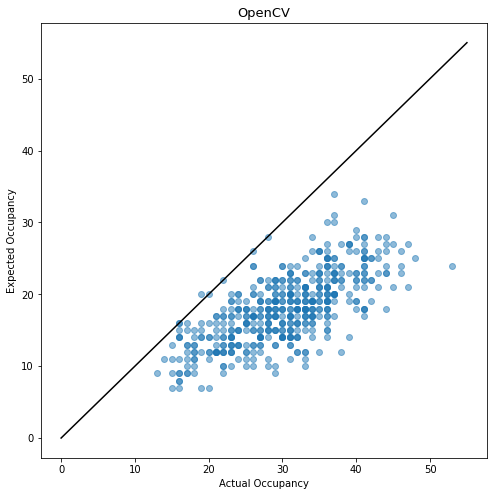

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

df = pd.DataFrame(output, columns=["actual", "counted", "error", "computeTime"])
rmse = round(sqrt(mean_squared_error(df["actual"], df["counted"])), 2)
avgErr = round(sum(df["error"])/len(df["error"]), 2)
avgComputeTime = round(sum(df["computeTime"])/len(df["computeTime"]), 2)

# print(df)
print("RMSE: ", rmse, "Average Percentage Error: ", avgErr, "Average Computing Time per Picture: ", avgComputeTime)
plt.figure(figsize=(8,8))
plt.title("OpenCV", fontsize=13)
plt.scatter(df["actual"], df["counted"], alpha=0.5)
plt.xlabel("Actual Occupancy", fontsize=10)
plt.ylabel("Expected Occupancy", fontsize=10)
plt.plot([0,55], [0,55], color="black")